## Black friday sales prediciton

In [18]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
file = '/Users/1/Documents/bl_fr/BlackFriday.csv'
bf = pd.read_csv(file)

## EDA

In [3]:
sns.set(style="darkgrid")
plt.style.use('tableau-colorblind10')

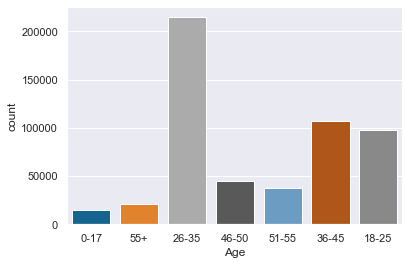

In [17]:
sns.countplot('Age', data=bf)

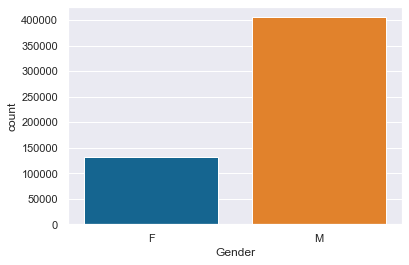

In [5]:
sns.countplot('Gender', data=bf)

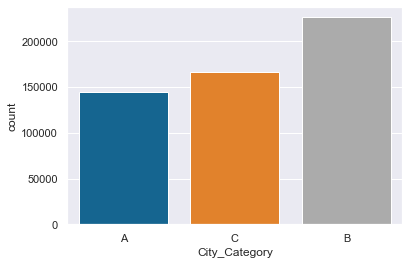

In [16]:
sns.countplot('City_Category', data=bf)

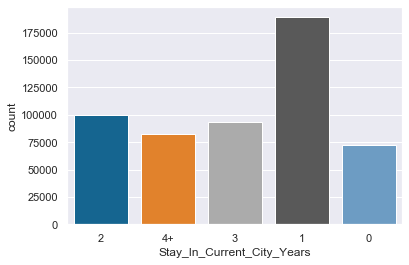

In [6]:
sns.countplot('Stay_In_Current_City_Years', data=bf)

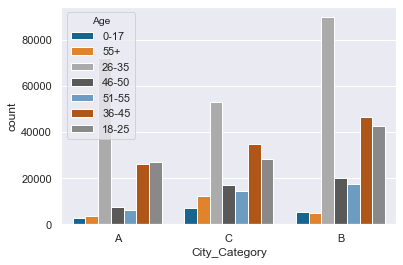

In [7]:
sns.countplot('City_Category',data=bf, hue='Age')

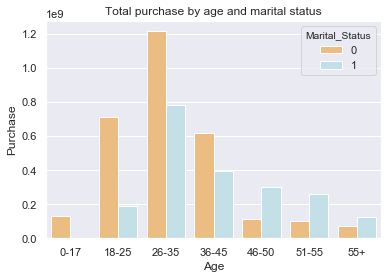

In [8]:
gr = bf.groupby(['Age', 'Marital_Status'])[['Purchase']].sum().reset_index()

sns.barplot(x="Age", y="Purchase", hue="Marital_Status", data=gr, palette="RdYlBu")
plt.title("Total purchase by age and marital status")
plt.show()


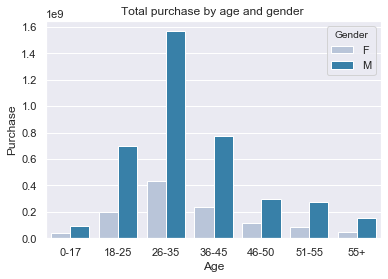

In [9]:
gr = bf.groupby(['Age', 'Gender'])[['Purchase']].sum().reset_index()
sns.barplot(x="Age", y="Purchase", hue="Gender", data=gr, palette="PuBu")
plt.title("Total purchase by age and gender ")
plt.show()


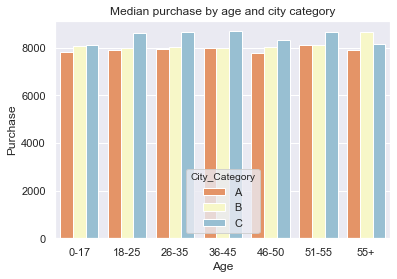

In [10]:
gr = bf.groupby(['Age', 'City_Category'])[['Purchase']].median().reset_index()
sns.barplot(x="Age", y="Purchase", hue="City_Category", data=gr, palette="RdYlBu")
plt.title("Median purchase by age and city category")
plt.show()

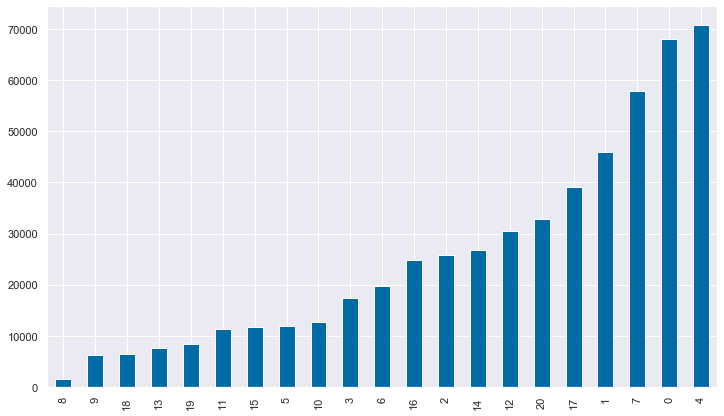

In [12]:
fig1, ax1 = plt.subplots(figsize=(12,7))
bf['Occupation'].value_counts().sort_values().plot('bar')

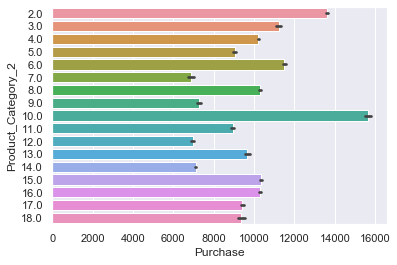

In [13]:
sns.barplot(x="Purchase", y="Product_Category_2", data=bf, orient='h')

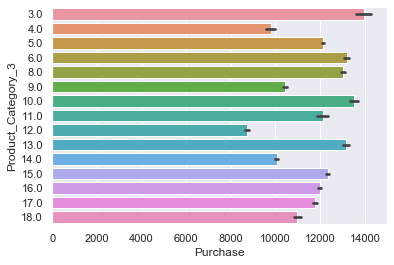

In [14]:
sns.barplot(x="Purchase", y="Product_Category_3", data=bf, orient='h')

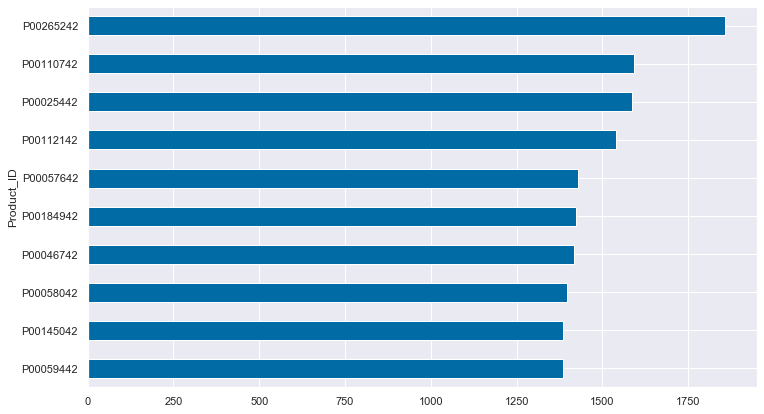

In [15]:
fig1, ax1 = plt.subplots(figsize=(12,7))
bf.groupby('Product_ID')['Purchase'].count().nlargest(10).sort_values().plot('barh')


## Data preperation

In [3]:
bf['Product_Category_3'].fillna(0, inplace=True)
bf['Product_Category_2'].fillna(0, inplace=True)



bf['Stay_In_Current_City_Years'] = bf['Stay_In_Current_City_Years'].apply(lambda x: int(x[0]) if x == '4+' else int(x))

# 1 - M; 0 - F
bf['Gender'] = bf['Gender'].apply(lambda x: 1 if x == 'M' else 0).astype('category')


dummies = pd.get_dummies(bf[['Age', 'City_Category']])
black_fr = pd.concat([bf, dummies], axis=1)

black_fr.drop(['Age', 'City_Category'], axis=1, inplace=True)

for col in ['Product_ID', 'User_ID']:    
    black_fr.loc[:, col] = LabelEncoder().fit_transform(black_fr[col])

black_fr.drop(['Product_ID', 'User_ID'], axis=1, inplace=True)

In [4]:
y = black_fr['Purchase']
black_fr.drop('Purchase', axis=1, inplace=True)

X = StandardScaler().fit_transform(black_fr.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size=0.33, random_state=42)

In [5]:
rf = RandomForestRegressor()
scores = cross_val_score(rf , X_train, y_train, cv=5)
print(scores)

[0.60478578 0.60295486 0.6026441  0.60257315 0.61200491]


In [6]:
rf.fit(X_train, y_train)
y_true_pred = rf.predict(X_test)
print(mean_squared_error(y_test, y_true_pred)**0.5)

3121.399097154782


In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 332.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 457.3min finished


{'n_estimators': 86,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [13]:
print(rf_random.best_score_ )
rf = rf_random.best_estimator_ 
y_pred = rf.predict(X_test)


y_true_pred = rf.predict(X_test)
print(mean_squared_error(y_test, y_true_pred)**0.5)

0.6497018000045266
2957.2671363119252


In [12]:

#data_dmatrix = xgb.DMatrix(data=X,label=y)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

print(mean_squared_error(y_test, preds)**0.5)

2997.0167404894087


In [7]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

num_round = 3

param = {'max_depth':7, 'objective':'reg:squarederror' }

bst = xgb.train(param, dtrain, num_round)

preds = bst.predict(dtest)

print(mean_squared_error(y_test, preds)**0.5)

4588.493808429447


In [8]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

print(mean_squared_error(y_test, preds)**0.5)

2997.0167404894087


In [9]:
xgb.XGBRegressor(objective ='reg:squarederror')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
# from xgboost.sklearn import XGBRegressor
# from sklearn.model_selection import GridSearchCV
# xgb1 = XGBRegressor()
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#                'objective':['reg:linear'], # reg:squarederror
#                'learning_rate': [.03, 0.05, .07], #so called `eta` value
#                'max_depth': [5, 6, 7],
#                'min_child_weight': [4],
#                'silent': [1],
#                'subsample': [0.7],
#                'colsample_bytree': [0.7],
#                'n_estimators': [500]}

# xgb_grid = GridSearchCV(xgb1,
#                          parameters,
#                          cv = 3,
#                          n_jobs = -1,
#                          verbose=True)

# xgb_grid.fit(X_train,y_train)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

In [10]:
from xgboost.sklearn import XGBRegressor
    
xgb1 = XGBRegressor(colsample_bytree=0.7, learning_rate=0.07, max_depth=7, min_child_weight=4, 
                    n_estimators= 500, nthread=4, objective='reg:squarederror', silent=1, 
                    subsample=0.7) 

xgb1.fit(X_train,y_train)
xgb_pred = xgb1.predict(X_test)
print(mean_squared_error(y_test, xgb_pred)**0.5)

2875.4896401987676


In [11]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)

dtest = xgb.DMatrix(data=X_test,label=y_test)

param = {'objective': 'reg:squarederror', 'booster': 'gbtree', 'silent': 1,
'max_depth': 10, 'eta': 0.1, 'nthread': 4,
'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 20,
'max_delta_step': 0, 'gamma': 0}

num_round = 690


bst = xgb.train(param, dtrain, num_round)

preds = bst.predict(dtest)

print(mean_squared_error(y_test, preds)**0.5)

2899.94198949305
